## Areial Robot/Car Model  

### Joseph Leung

<p>A nonholonomic WMR without wheel slips- ideal model- Unicycle with $r$, the radius, being one <p>
    
Our equations of motion are:<p>
$$
\begin{bmatrix}
\dot{q}\\
\end{bmatrix}=
\begin{bmatrix}
\dot{x}\\
\dot{y}\\
\dot{\theta}\\
\end{bmatrix} = 
\begin{bmatrix}
rcos(\theta) & 0\\
rsin(\theta) & 0\\
0 & 1\\
\end{bmatrix}
\begin{bmatrix}
V\\
\omega\\
\end{bmatrix}$$
    
which simplifies to: <p>
    $$
\begin{bmatrix}
\dot{x}\\
\dot{y}\\
\dot{\theta}\\
\end{bmatrix} = 
\begin{bmatrix}
Vcos(\theta)\\
Vsin(\theta)\\
\omega \\
\end{bmatrix} $$

    
    
with  $x$ ,  $y$,  and  $\theta$  being the position and heading of the robot, and  V  and $\omega$ being the control inputs.
    
where $\dot{x}$ is the $V_x$ velocity in the x direction, $\dot{y}$ is the $V_y$ velocity in the y direction, and $\dot{\theta}$ is the rate the heading of the robot changes. 

We start by initializing the properties of the mobile robot:

where M is the mass matrix, C is the matrix representing centrifugal and coriolis forces, g is gravity, K0 is for the potential energy, K2 is for the kinetic energy, and vel is the fixed velocity.

In [1]:
clc
close all
clear all

M=[80.8172 2.3194;
    2.3194 .2978];
C=[0 33.8664;
    -.8504 1.6854];
K0=[-80.9500 -2.5995;
    -2.5995 -.8033];
K2=[0 76.5973;
    0 2.6543];
g=9.81;
vel=5; 
Id=[1 0; 0 1];
zer=zeros(2);   

We derive our A and B from a general equation:<p>
$M(q)\ddot{q} + C(q,\dot{q}) + G(q) = \tau $<p>
Then we move everything to get the acceleration relation for joint angles:<p>
$\ddot{q} = M(q)^{-1}ff(q,\dot{q},\tau)$ <p>
    where $ff = \tau - C(q,\dot{q}) - G(q)$<p>
The expression can be linearized about a desired trajectory: <p>
$\ddot{\delta q} = \ddot{q} - \ddot{q}_d \approx \dfrac{\delta M(q)^{-1}ff} {\delta q} \Bigr\rvert_{q_d,\dot{q_d},\tau} \delta q + M(q_d)^{-1}\dfrac{\delta ff}{\delta \dot{q}}\Bigr\rvert_{q_d,\dot{q_d},\tau}\delta \dot{q} + M(q_d)^{-1}\dfrac{\delta ff}{\delta \tau}\Bigr\rvert_{q_d,\dot{q_d},\tau}\delta \tau$
 
$\ddot{\delta q} = \left(\dfrac{\delta M(q)^{-1}ff} {\delta q} \Bigr\rvert_{q_d,\dot{q_d},\tau} \circ ff \right) \delta q + M(q_d)^{-1} \dfrac{\delta ff} {\delta q} \Bigr\rvert_{q_d,\dot{q_d},\tau} + M(q_d)^{-1}\dfrac{\delta ff}{\delta \dot{q}}\Bigr\rvert_{q_d,\dot{q_d},\tau}\delta \dot{q} + M(q_d)^{-1}\dfrac{\delta ff}{\delta \tau}\Bigr\rvert_{q_d,\dot{q_d},\tau}\delta \tau$

The derivative of the inverse of $M(q)$ is equal to: <p>
$\dfrac{\delta M(q)^{-1}} {\delta q} = -M(q)^{-1}\dfrac{\delta M(q)} {\delta q} M(q)^{-1}$
    
We can then tranform the simplifed linear system with: <p>
$\dot{\delta q_1} = \delta q_2$
    
$\dot{\delta q_2} \approx \dfrac{\delta M(q)^{-1}ff} {\delta q} \Bigr\rvert_{q_d,\dot{q_d},\tau} \delta q_1 + M(q_d)^{-1}\dfrac{\delta ff}{\delta \dot{q}}\Bigr\rvert_{q_d,\dot{q_d},\tau} \delta q_2 + M(q_d)^{-1}\dfrac{\delta ff}{\delta \tau}\Bigr\rvert_{q_d,\dot{q_d},\tau}\delta \tau$

$\dfrac{d}{dt}\begin{bmatrix} \delta q_1 \\ \delta q_2 \end{bmatrix} = \begin{bmatrix} 0 &  I \\ \dfrac{\delta M(q)^{-1}ff} {\delta q} \Bigr\rvert_{q_d,\dot{q_d},\tau} & M(q_d)^{-1}\dfrac{\delta ff}{\delta \dot{q}}\Bigr\rvert_{q_d,\dot{q_d},\tau}  \end{bmatrix}\begin{bmatrix} \delta q_1 \\ \delta q_2 \end{bmatrix} + \begin{bmatrix} 0 \\ M(q_d)^{-1}\dfrac{\delta ff}{\delta \tau}\Bigr\rvert_{q_d,\dot{q_d},\tau} \end{bmatrix} \tau$

The equations above will be our linear approximation of the system dynamics

In [4]:
Min=inv(M);
A=[-vel*Min*C, -Min.*(g*K0+vel^2*K2) ; %I just flipped the matrix 
    Id , zer];
B=[Min;zer];
C=[zer,Id];
D=[zer];
M_A = ctrb(A,B);
Rank=rank(M_A); %full rank means controllable 
[v,d]=eig(A);
Ob=obsv(A,C);
RankO=rank(Ob); %full rank means observable

Now we will created a path and match it with a given velocity to give us time it should take to get to the end. 

In [5]:
%path 
x=-1:.05:1;
y=.4*((1+exp(12*(x))).^-1); 
y=fliplr(y);
theta(1)=0;
x=50*x;
x=x+50;
y=30*y;

path=[x',y'];
[t, x_des, y_des,dt] = pointToTrajectory(path,0,vel);
for f= 2: length(x_des)
theta(f)=tan((y_des(f)-y_des(f-1))/(x_des(f)-x_des(f-1)));
end


Here we design a LQR controller for the WMR by picking values of Q and R. When picking values of Q and R if the trajectory matters more we want the norm(R) >> norm(Q). Then I am initializing the states of the position and heading angle for the actual and estimated states.

In [7]:
Q = .01*eye(4);
R = 2^-2*eye(2); %i wanna follow trajectory 
%Kvalue = LQR_k(A,B,Q,R);

X_0 = [0;0;0];
X_hat_0 = X_0/2;

Ch = [1 0 0;
    0 1 0];
P_pl = eye(3);
X(:,1)= X_0;
Y(:,1) = Ch*X(:,1);
t(1) = 0;
X_hat(:,1)= X_hat_0;
QQ = .01*eye(2);
tt(1)=0;


Here we are going to have our WMR try to follow the path we created. <p>
First we find X(i+1) for both the estimated states and actual states using the equations of motion given in the beginning and find y from our obeserver.<p>
Then we solve for P with the Riccati equation. 
Lastly solve for K to minimize the error from our estimated stated and actual states. 

In [8]:
for i = 1:length(t)
    u = [vel;theta(i)]; 
%the real thing 
X(:,i+1)= X(:,i) + dt*[u(1)*abs(cos(X(3,i)));
        u(1)*sin(X(3,i));
        u(2)];

    tt(i+1) = tt(i)+dt;
    Y(:,i+1) = Ch*X(:,i+1) + sqrt(R)*randn(size(Ch,1),1); 
    
dFdx = [0 0 -vel*sin(X_hat(3,i)); 0 0 vel*cos(X_hat(3,i)); 0 0 0 ];
    dFdx_d = eye(3) + dt*dFdx;
    
    F = [dt*cos(X_hat(3,i)) 0;
    dt*sin(X_hat(3,i)) 0;
    0 dt];
    
    P_mi = dFdx_d*P_pl*dFdx_d' + F*QQ*F';
       
    X_hat(:,i+1) = X_hat(:,i) + dt*[u(1)*cos(X_hat(3,i));
            u(1)*sin(X_hat(3,i));
          u(2);];
    Y_hat(:,i+1) = Ch*X_hat(:,i+1);
    % Update based on measurement
    e_Y  = Y(:,i+1) - Y_hat(:,i+1);
    S = Ch*P_mi*Ch'+R;
    K = P_mi*Ch'*inv(S);
    P_pl = (eye(3) - K*Ch)*P_mi;
    X_hat(:,i+1)=X_hat(:,i+1) + K*e_Y;
end

X_hat(3,1) = X_hat(3,end);
P_pl = P_mi;

We can see from our results we were able to have our WMR follow the path we created following a smooth path though it was not perfect. If I were to add more things to the model to make it more exact like traction to the wheels and control of two wheels I would be able to follow the path better. 

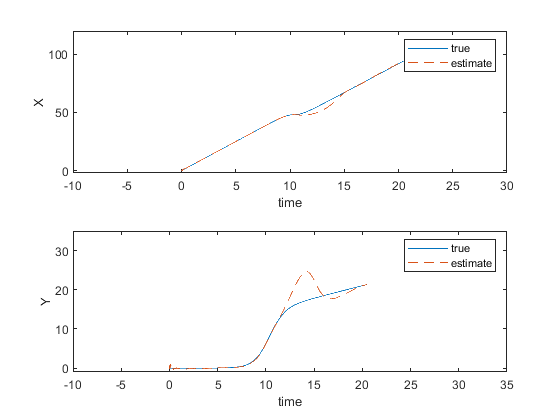

In [9]:
figure;
subplot(2,1,1)
plot(tt,X(1,:),tt,X_hat(1,:),'--')
legend('true','estimate')
%axis([0 2.5 0 40])
xlabel('time')
ylabel('X')
axis([-10 30 -2 120])
subplot(2,1,2)
plot(tt,X(2,:),tt,X_hat(2,:),'--')
legend('true','estimate')
xlabel('time')
ylabel('Y')
axis([-10 35 -1 35])

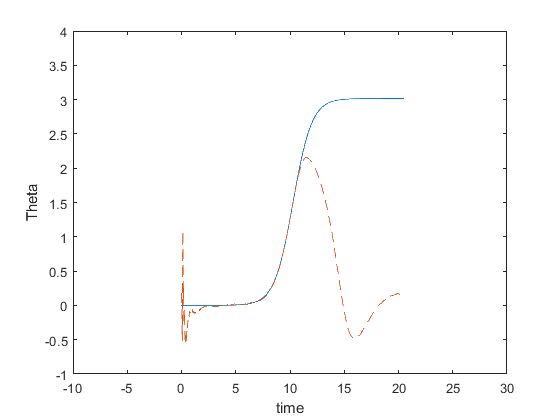

In [10]:
figure;
plot(tt,X(3,:),tt,X_hat(3,:),'--') %X is the actual while X_hat is the measurement based on dynamics
axis([-10 30 -1 4])
xlabel('time')
ylabel('Theta')
%axis([0 2.5 0 2])